In [57]:
import os
import pandas as pd
import pathlib
import shutil
from PIL import Image
import numpy as np
import torch
import dask
import asyncio
import ray
from queue import Queue

In [ ]:
train_files = pd.read_csv("msd_data/splitting_edited_train_edited.csv",index_col=None)
val_files = pd.read_csv("msd_data/splitting_edited_val_edited.csv",index_col=None)
test_files = pd.read_csv("msd_data/splitting_edited_test_edited.csv",index_col=None)

In [ ]:
test_files.head(10)

In [ ]:
# train_files_folders = train_files["folders"]
# train_files_number = train_files["number"]

# val_files_folders = val_files["folders"]
# val_files_folders = val_files["number"]

# test_files_folders = test_files["folders"]
# test_files_folders = test_files["number"]


In [ ]:
train_files["folders"] = train_files["folders"].replace("^./*","msd_data/",regex=True)
val_files["folders"] = val_files["folders"].replace("^./*","msd_data/",regex=True)
test_files["folders"] = test_files["folders"].replace("^./*","msd_data/",regex=True)
combined_files = pd.concat([train_files,val_files,test_files])
combined_files


In [ ]:
def calc_weights(w1,w2,label):
    """
    W1: Weighting for pixels that are proximal to tissue-transition regions. E.g pixels near the boundary/edges between to different segments
        Equates one if gradient between 2 pixels is more than 1 -> If the pixel (x) is besides
    W2: Equals one if the class label belongs to an under-represented class
    
    """
    # raw_tensor = torch.from_numpy(raw) 
    label_tensor = torch.from_numpy(label)
    
    # shape is (H,W)
    # print(label_tensor.shape)
    # Calculating the weights for W1

    # Initialise w1 weight map with all zeroes first
    w1_map = torch.zeros(label_tensor.shape)
    # print(f"Initialised w1_map \n {w1_map.shape}")
    # print("Calculating w1 map...")

    num_rows = label_tensor.shape[0]
    for row in range(1,num_rows):
        # We use row and row-1 so that we won't get an index out of bounds error while
        # iterating
        first_row = label_tensor[row-1,:]
        second_row = label_tensor[row,:]
        prev_a = None
        prev_b = None

        # iterate through each column in each rows
        # print(len(first_row))
        for col in range(len(first_row)):
            a = first_row[col]
            b = second_row[col]
            if a != b:
                # There exists a boundary between a and b, so we should weigh these pixels
                w1_map[row-1,col] = 1
                w1_map[row,col] = 1
            else:
                # if we are not at the first(leftmost) col, we check if pixels side by side are the same
                # If they are not the same, there exists a boundary between a/b and prev_a/b so we should weigh
                # these pixels
                if (col != 0) and (prev_a is not None) and (prev_b is not None):
                    if a != prev_a:
                        w1_map[row-1,col] = 1
                        w1_map[row-1,col-1] = 1
                    if b != prev_b:
                        w1_map[row,col] = 1
                        w1_map[row,col-1] = 1
                elif (col != 0 ) and (prev_a is None) and (prev_b is None):
                    raise Exception(f"Something went wrong, we were at row {row} col {col} and prev_a or prev_b is NOT none. prev_a:{prev_a}, prev_b:{prev_b}")
                else:
                    # We are at the first(leftmost) col, and prev_a and prev_b is None so there is nothing to compare to
                    pass
            prev_a = a
            prev_b = b
    # End
    # print(f"Finished calculating W1 map")
    # print(w1_map)
    w1_map.float()
    # Initialise w2 weight map with all zeroes first
    w2_map = torch.zeros(label_tensor.shape)
    # class label/idx 2 is the "dominant" class so we will weigh the pixels with a class label that is != 2
    # w2_map = torch.eq(label_tensor,2).long()
    w2_map = torch.eq(label_tensor,2)
    # return 1 if value of w2_map = False, else return 0
    w2_map = torch.where(w2_map == False,1,0).float()
    # weighted_map = 1 + (w1*w1_map) + (w2*w2_map)
    # print(f"W1 : {w1}")
    # print(f"W1_map is \n {w1_map}\n")
    # print(f"W2 : {w2}")
    # print(f"W2_map is \n {w2_map}\n")
    # print(f"W1_weighted is : {(w1*w1_map)}\n")
    # print(f"W2_weighted is : {(w2*w2_map)}\n")
    # print(f"W1_weighted + W2_weighted is {np.add((w1*w1_map),(w2*w2_map))}")
    # print(f"w1 type is : {w1_map.type()}")
    # print(f"w2 type is : {w2_map.type()}")
    # print(f"one_map shape is {one_map.shape}")
    w1_weighted_map = w1 * w1_map
    w2_weighted_map = w2 * w2_map
    one_map = torch.ones(w1_map.shape)
    w1w2_map = torch.add(w1_weighted_map,w2_weighted_map)
    weighted_map = torch.add(one_map,w1w2_map)
    return weighted_map
    


In [ ]:
def prep_msd_data(combined_files,dest,w1,w2):
    path = os.getcwd()
    # make dirs if not exists
    if not os.path.exists(dest):
        # make dir
        data_dest_root = os.path.join(path,dest,"data")
        display_dest_root = os.path.join(path,dest,"display")
        seg_dest_root = os.path.join(path,dest,"segmentations")
        weight_dest_root = os.path.join(path,dest,"weights")

        data_train_path = os.path.join(data_dest_root,"train")
        data_val_path = os.path.join(data_dest_root,"val")
        data_test_path = os.path.join(data_dest_root,"test")

        display_train_path = os.path.join(display_dest_root,"train")
        display_val_path = os.path.join(display_dest_root,"val")
        display_test_path = os.path.join(display_dest_root,"test")

        seg_train_path = os.path.join(seg_dest_root,"train")
        seg_val_path = os.path.join(seg_dest_root,"val")
        seg_test_path = os.path.join(seg_dest_root,"test")

        weight_train_path = os.path.join(weight_dest_root,"train")
        weight_val_path = os.path.join(weight_dest_root,"val")
        weight_test_path = os.path.join(weight_dest_root,"test")

        pathlib.Path(data_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(display_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(seg_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(weight_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_test_path).mkdir(parents=True,exist_ok=True)
    else:
        print("ALRDY EXISTS")

    # iterate through train,val and test
    set_files = {}
    
    for each in combined_files.itertuples():
        # Indices are (index,folder,mode,number,partition#)
        file_path = each[1]
        # file_path = file_path.replace("\\","/")
        # print(file_path)
        file_type = each[2]
        file_num = each[3]
        file_partition = each[4]
        set_files[file_path] = {"type":file_type,"num":file_num,"identifier":file_partition}
      
        # print(f"File path is {file_path}, file type is {file_type}, identifier num is {file_identifier}")
    # return set_files
    count = 1
    path = os.getcwd()
    for root,dirs,files in os.walk("msd_data/"):
        # if count %100==0:
        #     print(count)    
        root = root.replace("\\","/")
        if (root in set_files) and (set_files[root]["type"] == "train"):
            # print(root)
            # print(files)
            for f in files:
                root_split = root.split("/")
                prefix = root_split[-1]
                display_root = root.replace("/Data/","/Display/")
                seg_root = root.replace("/Data/","/Segmentations/")
                # no need for weight_root?
                weight_root = root.replace("/Data/","weights")

                f_new = f.replace(".tif","_display.png")
                # Removes the _display suffix to bring the filename inline with the ones in the Data folder
                f_std = f_new.replace("_display.png",".png")
                f_seg = f.replace(".tif",".png")
                file_new_name = prefix + f
                file_new_name2 = prefix + f_std
                file_new_name_seg = prefix + f_seg
                weight_file_name = file_new_name_seg.split(".")[0]
                
                # source
                source_cur_path = os.path.join(path,root,f)
                source_dest_path = os.path.join(data_train_path,file_new_name)
                # ground truth segmentation mask
                display_cur_path = os.path.join(path,display_root,f_new)
                display_dest_path = os.path.join(display_train_path,file_new_name2)
                # black background
                seg_cur_path = os.path.join(path,seg_root,f_seg)
                seg_dest_path = os.path.join(seg_train_path,file_new_name_seg)
                # calculate weight of the image
                label_img = Image.open(source_cur_path)
                label_arr = np.array(label_img)
                weight_map = calc_weights(w1,w2,label_arr)
                # save weightmap as image
                weight_dest_path = os.path.join(weight_train_path,weight_file_name)
                weight_map_arr = np.array(weight_map)
                

                shutil.copy(source_cur_path,source_dest_path)
                shutil.copy(display_cur_path,display_dest_path)
                shutil.copy(seg_cur_path,seg_dest_path)
                np.save(weight_dest_path,weight_map_arr)
        elif (root in set_files) and (set_files[root]["type"] == "val"):
        #     print(root)
        #     print(files)
            for f in files:
                root_split = root.split("/")
                prefix = root_split[-1]
                # print(root)
                display_root = root.replace("/Data/","/Display/")
                seg_root = root.replace("/Data/","/Segmentations/")

                f_new = f.replace(".tif","_display.png")
                # Removes the _display suffix to bring the filename inline with the ones in the Data folder
                f_std = f_new.replace("_display.png",".png")
                f_seg = f.replace(".tif",".png")
                file_new_name = prefix + f
                file_new_name2 = prefix + f_std
                file_new_name_seg = prefix + f_seg
                weight_file_name = file_new_name_seg.split(".")[0]
                
                # source
                source_cur_path = os.path.join(path,root,f)
                source_dest_path = os.path.join(data_val_path,file_new_name)
                # ground truth segmentation mask
                display_cur_path = os.path.join(path,display_root,f_new)
                display_dest_path = os.path.join(display_val_path,file_new_name2)
                # black background
                seg_cur_path = os.path.join(path,seg_root,f_seg)
                seg_dest_path = os.path.join(seg_val_path,file_new_name_seg)
                # calculate weight of the image
                label_img = Image.open(source_cur_path)
                label_arr = np.array(label_img)
                weight_map = calc_weights(w1,w2,label_arr)
                # save weightmap as image
                weight_dest_path = os.path.join(weight_val_path,weight_file_name)
                weight_map_arr = np.array(weight_map)


                shutil.copy(source_cur_path,source_dest_path)
                shutil.copy(display_cur_path,display_dest_path)
                shutil.copy(seg_cur_path,seg_dest_path)
                np.save(weight_dest_path,weight_map_arr)
        elif (root in set_files) and (set_files[root]["type"] == "test"):
            for f in files:
                root_split = root.split("/")
                prefix = root_split[-1]

                display_root = root.replace("/Data/","/Display/")

                seg_root = root.replace("/Data/","/Segmentations/")

                f_new = f.replace(".tif","_display.png")
                # Removes the _display suffix to bring the filename inline with the ones in the Data folder
                f_std = f_new.replace("_display.png",".png")
                f_seg = f.replace(".tif",".png")
                file_new_name = prefix + f
                file_new_name2 = prefix + f_std
                file_new_name_seg = prefix + f_seg
                weight_file_name = file_new_name_seg.split(".")[0]
                
                # source
                source_cur_path = os.path.join(path,root,f)
                source_dest_path = os.path.join(data_test_path,file_new_name)
                # ground truth segmentation mask
                display_cur_path = os.path.join(path,display_root,f_new)
                display_dest_path = os.path.join(display_test_path,file_new_name2)
                # black background
                seg_cur_path = os.path.join(path,seg_root,f_seg)
                seg_dest_path = os.path.join(seg_test_path,file_new_name_seg)
                # calculate weight of the image
                label_img = Image.open(source_cur_path)
                label_arr = np.array(label_img)
                weight_map = calc_weights(w1,w2,label_arr)
                # save weightmap as image
                weight_dest_path = os.path.join(weight_test_path,weight_file_name)
                weight_map_arr = np.array(weight_map)
                
 
                shutil.copy(source_cur_path,source_dest_path)
                shutil.copy(display_cur_path,display_dest_path)
                shutil.copy(seg_cur_path,seg_dest_path)
                np.save(weight_dest_path,weight_map_arr)
                
  


In [ ]:
destination = "data_raw_img"
prep_msd_data(combined_files,destination,w1=10,w2=5)

# destination = "data"
# results = prep_msd_data_dask(combined_files,destination,w1=10,w2=5)
# results = prep_msd_data_dask(combined_files,destination,w1=10,w2=5)
# results = dask.delayed(prep_msd_data_dask)(combined_files,destination,w1=10,w2=5)
# final = dask.compute(results)
# results.visualize()

In [ ]:
print(len(os.listdir("data/segmentations/train/")))

In [ ]:
# seg = sorted(os.listdir("data/segmentations/train"))
# seg_img = Image.open("data/segmentations/train/" + seg[0])
# raw = sorted(os.listdir("data/data/train"))
# raw_img = Image.open("data/data/train/" + raw[0])


In [ ]:
# raw_array = np.array(raw_img)
# seg_array = np.array(seg_img)
# np.unique(seg_array)

In [ ]:
# def calc_weights(w1,w2,label):
#     """
#     W1: Weighting for pixels that are proximal to tissue-transition regions. E.g pixels near the boundary/edges between to different segments
#         Equates one if gradient between 2 pixels is more than 1 -> If the pixel (x) is besides
#     W2: Equals one if the class label belongs to an under-represented class
    
#     """
#     # raw_tensor = torch.from_numpy(raw) 
#     label_tensor = torch.from_numpy(label)
    
#     # shape is (H,W)
#     # print(label_tensor.shape)
#     # Calculating the weights for W1

#     # Initialise w1 weight map with all zeroes first
#     w1_map = torch.zeros(label_tensor.shape)
#     # print(f"Initialised w1_map \n {w1_map.shape}")
#     # print("Calculating w1 map...")

#     num_rows = label_tensor.shape[0]
#     for row in range(1,num_rows):
#         # We use row and row-1 so that we won't get an index out of bounds error while
#         # iterating
#         first_row = label_tensor[row-1,:]
#         second_row = label_tensor[row,:]
#         prev_a = None
#         prev_b = None

#         # iterate through each column in each rows
#         # print(len(first_row))
#         for col in range(len(first_row)):
#             a = first_row[col]
#             b = second_row[col]
#             if a != b:
#                 # There exists a boundary between a and b, so we should weigh these pixels
#                 w1_map[row-1,col] = 1
#                 w1_map[row,col] = 1
#             else:
#                 # if we are not at the first(leftmost) col, we check if pixels side by side are the same
#                 # If they are not the same, there exists a boundary between a/b and prev_a/b so we should weigh
#                 # these pixels
#                 if (col != 0) and (prev_a is not None) and (prev_b is not None):
#                     if a != prev_a:
#                         w1_map[row-1,col] = 1
#                         w1_map[row-1,col-1] = 1
#                     if b != prev_b:
#                         w1_map[row,col] = 1
#                         w1_map[row,col-1] = 1
#                 elif (col != 0 ) and (prev_a is None) and (prev_b is None):
#                     raise Exception(f"Something went wrong, we were at row {row} col {col} and prev_a or prev_b is NOT none. prev_a:{prev_a}, prev_b:{prev_b}")
#                 else:
#                     # We are at the first(leftmost) col, and prev_a and prev_b is None so there is nothing to compare to
#                     pass
#             prev_a = a
#             prev_b = b
#     # End
#     # print(f"Finished calculating W1 map")
#     # print(w1_map)
#     w1_map.float()
#     # Initialise w2 weight map with all zeroes first
#     w2_map = torch.zeros(label_tensor.shape)
#     # class label/idx 2 is the "dominant" class so we will weigh the pixels with a class label that is != 2
#     # w2_map = torch.eq(label_tensor,2).long()
#     w2_map = torch.eq(label_tensor,2)
#     # return 1 if value of w2_map = False, else return 0
#     w2_map = torch.where(w2_map == False,1,0).float()
#     # weighted_map = 1 + (w1*w1_map) + (w2*w2_map)
#     # print(f"W1 : {w1}")
#     # print(f"W1_map is \n {w1_map}\n")
#     # print(f"W2 : {w2}")
#     # print(f"W2_map is \n {w2_map}\n")
#     # print(f"W1_weighted is : {(w1*w1_map)}\n")
#     # print(f"W2_weighted is : {(w2*w2_map)}\n")
#     # print(f"W1_weighted + W2_weighted is {np.add((w1*w1_map),(w2*w2_map))}")
#     # print(f"w1 type is : {w1_map.type()}")
#     # print(f"w2 type is : {w2_map.type()}")
#     # print(f"one_map shape is {one_map.shape}")
#     w1_weighted_map = w1 * w1_map
#     w2_weighted_map = w2 * w2_map
#     one_map = torch.ones(w1_map.shape)
#     w1w2_map = torch.add(w1_weighted_map,w2_weighted_map)
#     weighted_map = torch.add(one_map,w1w2_map)
#     return weighted_map
    


In [ ]:
# calc_weights(10,5,raw_array,seg_array)

In [ ]:
# test = np.zeros((7,5))
# test[2] = [0,0,1,0,0]
# test[3] = [1,1,1,1,1]
# test[4] = [1,1,1,1,1]
# test[5] = [2,2,1,2,2]
# test[6] = [2,2,2,2,2]
# print(test)

In [ ]:
# calc_weights(1,1,raw_array,test)

In [ ]:
def check_dirs(dest:str)->None:
    # Checking of dirs should not be async
    path = os.getcwd()
    if not os.path.exists(dest):
        # make dir
        data_dest_root = os.path.join(path,dest,"data")
        display_dest_root = os.path.join(path,dest,"display")
        seg_dest_root = os.path.join(path,dest,"segmentations")
        weight_dest_root = os.path.join(path,dest,"weights")

        data_train_path = os.path.join(data_dest_root,"train")
        data_val_path = os.path.join(data_dest_root,"val")
        data_test_path = os.path.join(data_dest_root,"test")

        display_train_path = os.path.join(display_dest_root,"train")
        display_val_path = os.path.join(display_dest_root,"val")
        display_test_path = os.path.join(display_dest_root,"test")

        seg_train_path = os.path.join(seg_dest_root,"train")
        seg_val_path = os.path.join(seg_dest_root,"val")
        seg_test_path = os.path.join(seg_dest_root,"test")

        weight_train_path = os.path.join(weight_dest_root,"train")
        weight_val_path = os.path.join(weight_dest_root,"val")
        weight_test_path = os.path.join(weight_dest_root,"test")

        pathlib.Path(data_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(display_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(seg_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(weight_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_test_path).mkdir(parents=True,exist_ok=True)
    else:
        print("ALRDY EXISTS")

In [ ]:
async def calc_weights_async(w1:int,w2:int,queue:asyncio.Queue,output_queue:asyncio.Queue):
    """
    W1: Weighting for pixels that are proximal to tissue-transition regions. E.g pixels near the boundary/edges between to different segments
        Equates one if gradient between 2 pixels is more than 1 -> If the pixel (x) is besides
    W2: Equals one if the class label belongs to an under-represented class
    
    """
    details = queue.get()
    label=details["source"]
    dest = details["dest"]
    label_img = Image.open(label)
    label_arr = np.array(label_img)
    # raw_tensor = torch.from_numpy(raw) 
    label_tensor = torch.from_numpy(label_arr)
    
    # Calculating the weights for W1
    # Initialise w1 weight map with all zeroes first
    w1_map = torch.zeros(label_tensor.shape)
    # print(f"Initialised w1_map \n {w1_map.shape}")
    # print("Calculating w1 map...")

    num_rows = label_tensor.shape[0]
    for row in range(1,num_rows):
        # We use row and row-1 so that we won't get an index out of bounds error while
        # iterating
        first_row = label_tensor[row-1,:]
        second_row = label_tensor[row,:]
        prev_a = None
        prev_b = None

        # iterate through each column in each rows
        # print(len(first_row))
        for col in range(len(first_row)):
            a = first_row[col]
            b = second_row[col]
            if a != b:
                # There exists a boundary between a and b, so we should weigh these pixels
                w1_map[row-1,col] = 1
                w1_map[row,col] = 1
            else:
                # if we are not at the first(leftmost) col, we check if pixels side by side are the same
                # If they are not the same, there exists a boundary between a/b and prev_a/b so we should weigh
                # these pixels
                if (col != 0) and (prev_a is not None) and (prev_b is not None):
                    if a != prev_a:
                        w1_map[row-1,col] = 1
                        w1_map[row-1,col-1] = 1
                    if b != prev_b:
                        w1_map[row,col] = 1
                        w1_map[row,col-1] = 1
                elif (col != 0 ) and (prev_a is None) and (prev_b is None):
                    raise Exception(f"Something went wrong, we were at row {row} col {col} and prev_a or prev_b is NOT none. prev_a:{prev_a}, prev_b:{prev_b}")
                else:
                    # We are at the first(leftmost) col, and prev_a and prev_b is None so there is nothing to compare to
                    pass
            prev_a = a
            prev_b = b
    # End

    # print(f"Finished calculating W1 map")
    # print(w1_map)
    w1_map.float()

    # Initialise w2 weight map with all zeroes first
    w2_map = torch.zeros(label_tensor.shape)
    # class label/idx 2 is the "dominant" class so we will weigh the pixels with a class label that is != 2
    # w2_map = torch.eq(label_tensor,2).long()
    w2_map = torch.eq(label_tensor,2)
    # return 1 if value of w2_map = False, else return 0
    w2_map = torch.where(w2_map == False,1,0).float()
    # weighted_map = 1 + (w1*w1_map) + (w2*w2_map)
    # print(f"W1 : {w1}")
    # print(f"W1_map is \n {w1_map}\n")
    # print(f"W2 : {w2}")
    # print(f"W2_map is \n {w2_map}\n")
    # print(f"W1_weighted is : {(w1*w1_map)}\n")
    # print(f"W2_weighted is : {(w2*w2_map)}\n")
    # print(f"W1_weighted + W2_weighted is {np.add((w1*w1_map),(w2*w2_map))}")
    # print(f"w1 type is : {w1_map.type()}")
    # print(f"w2 type is : {w2_map.type()}")
    # print(f"one_map shape is {one_map.shape}")
    w1_weighted_map = w1 * w1_map
    w2_weighted_map = w2 * w2_map
    one_map = torch.ones(w1_map.shape)
    w1w2_map = torch.add(w1_weighted_map,w2_weighted_map)
    weighted_map = torch.add(one_map,w1w2_map)
    output_details={
        "dest":dest,
        "weights":weighted_map
    }
    await output_queue.put(output_details)
    return weighted_map
    

In [ ]:
async def create_dest_async(train_val_test_paths,path,root,set_files,f,paths_queue,calc_weights_queue):
    data_train_path = train_val_test_paths["data_train_path"]
    data_val_path = train_val_test_paths["data_val_path"]
    data_test_path = train_val_test_paths["data_test_path"]

    display_train_path = train_val_test_paths["display_train_path"]
    display_val_path = train_val_test_paths["display_val_path"]
    display_test_path = train_val_test_paths["display_test_path"]

    seg_train_path = train_val_test_paths["seg_train_path"]
    seg_val_path = train_val_test_paths["seg_val_path"]
    seg_test_path = train_val_test_paths["seg_test_path"]

    weight_train_path = train_val_test_paths["weight_train_path"]
    weight_val_path = train_val_test_paths["weight_val_path"]
    weight_test_path = train_val_test_paths["weight_test_path"]
    
    root_split = root.split("/")
    prefix = root_split[-1]
    display_root = root.replace("/Data/","/Display/")
    seg_root = root.replace("/Data/","/Segmentations/")
    # no need for weight_root?
    weight_root = root.replace("/Data/","weights")

    f_new = f.replace(".tif","_display.png")
    # Removes the _display suffix to bring the filename inline with the ones in the Data folder
    f_std = f_new.replace("_display.png",".png")
    f_seg = f.replace(".tif",".png")
    file_new_name = prefix + f
    file_new_name2 = prefix + f_std
    file_new_name_seg = prefix + f_seg
    weight_file_name = file_new_name_seg.split(".")[0]

    # source
    source_cur_path = os.path.join(path,root,f)
    # ground truth segmentation mask
    display_cur_path = os.path.join(path,display_root,f_new)
    # black background
    seg_cur_path = os.path.join(path,seg_root,f_seg)
    # creation of dest paths are sequential 
    if (set_files[root]["type"] == "train"):
        source_dest_path = os.path.join(data_train_path,file_new_name)
        display_dest_path = os.path.join(display_train_path,file_new_name2)
        seg_dest_path = os.path.join(seg_train_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_train_path,weight_file_name)
    elif (set_files[root]["type"] == "val"):
        source_dest_path = os.path.join(data_val_path,file_new_name)
        display_dest_path = os.path.join(display_val_path,file_new_name2)
        seg_dest_path = os.path.join(seg_val_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_val_path,weight_file_name)
    elif (set_files[root]["type" == "test"]):
        source_dest_path = os.path.join(data_test_path,file_new_name)
        display_dest_path = os.path.join(display_test_path,file_new_name2)
        seg_dest_path = os.path.join(seg_test_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_test_path,weight_file_name)
    else:
        raise Exception("Error, unknown type")
    dest_paths = {
        "source_dest_path":source_dest_path,
        "display_dest_path":display_dest_path,
        "seg_dest_path":seg_dest_path,
        "weight_dest_path":weight_dest_path
    }
    paths_queue.put(dest_paths)
    weights_details={
        "source":source_cur_path,
        "dest":weight_dest_path
    }
    calc_weights_queue.put(weights_details)


async def copy_files_async(queue=asyncio.Queue):
    paths = queue.get()
    shutil.copy(paths["source_cur_path"],paths["source_dest_path"])
    shutil.copy(paths["display_cur_path"],paths["display_dest_path"])
    shutil.copy(paths["seg_cur_path"],paths["seg_dest_path"])
    queue.task_done()


async def save_weights_async(queue=asyncio.Queue):
    """
    queue: Contains a dictionary containing the following 
        dest => Destination file path to save the weights to
        weights => The calculated weights    
    """
    details=queue.get()
    file_path=details["dest"]
    weights=details["weights"]
    np.save(file_path,weights)
    queue.task_done()

async def prep_msd_data_async(combined_files,dest,w1,w2):
    """
    Does the following
    1. Check if destination directories exists
    1a.Create directories if not exists
    2. Get file types(E.g train/test/val),num_files and partitions as an iterable
    3. Iterate through the files in the MSD raw dataset and do the following operations:-
    3a.Calculate weights asynchronously and add the calculated weights to a queue
    3b.Rename the files in the Data,Dispaly,Segmentations folders in the raw data and add the destination filepaths to a queue
    4. Async writers/processes will copy/write everything in the queue to their destinations

    There are 3 queues:
    1. paths_queue -> contains dictionary containing the source and destination paths of MSD images to copy from/to
    2. weights_calc_queue -> contains source path of the image that will be used to calculate the weights
    3. weights_queue -> contains the 
    Create_paths creates a dictionary of the paths and adds it to a queue

    """
    check_dirs(dest=dest)
    path = os.getcwd()
    # make dirs if not exists
    if not os.path.exists(dest):
        # make dir
        data_dest_root = os.path.join(path,dest,"data")
        display_dest_root = os.path.join(path,dest,"display")
        seg_dest_root = os.path.join(path,dest,"segmentations")
        weight_dest_root = os.path.join(path,dest,"weights")

        data_train_path = os.path.join(data_dest_root,"train")
        data_val_path = os.path.join(data_dest_root,"val")
        data_test_path = os.path.join(data_dest_root,"test")

        display_train_path = os.path.join(display_dest_root,"train")
        display_val_path = os.path.join(display_dest_root,"val")
        display_test_path = os.path.join(display_dest_root,"test")

        seg_train_path = os.path.join(seg_dest_root,"train")
        seg_val_path = os.path.join(seg_dest_root,"val")
        seg_test_path = os.path.join(seg_dest_root,"test")

        weight_train_path = os.path.join(weight_dest_root,"train")
        weight_val_path = os.path.join(weight_dest_root,"val")
        weight_test_path = os.path.join(weight_dest_root,"test")

        pathlib.Path(data_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(data_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(display_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(display_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(seg_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(seg_test_path).mkdir(parents=True,exist_ok=True)

        pathlib.Path(weight_train_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_val_path).mkdir(parents=True,exist_ok=True)
        pathlib.Path(weight_test_path).mkdir(parents=True,exist_ok=True)
    else:
        print("ALRDY EXISTS")

    # iterate through train,val and test
    set_files = {}
    train_val_test_paths = {
        "data_train_path" : data_train_path,
        "data_val_path" : data_val_path,
        "data_test_path" : data_test_path,
        "display_train_path" : display_train_path,
        "display_val_path" : display_val_path,
        "display_test_path" : display_test_path,
        "seg_train_path" : seg_train_path,
        "seg_val_path" : seg_val_path,
        "seg_test_path" : seg_test_path,
        "weight_train_path" : weight_train_path,
        "weight_val_path" : weight_val_path,
        "weight_test_path" : weight_test_path
    }
    for each in combined_files.itertuples():
        # Indices are (index,folder,mode,number,partition#)
        file_path = each[1]
        # file_path = file_path.replace("\\","/")
        # print(file_path)
        file_type = each[2]
        file_num = each[3]
        file_partition = each[4]
        set_files[file_path] = {"type":file_type,"num":file_num,"identifier":file_partition}
      
        # print(f"File path is {file_path}, file type is {file_type}, identifier num is {file_identifier}")
    # return set_files
    count = 1
    path = os.getcwd()
    paths_queue = asyncio.Queue()
    calc_weights_queue = asyncio.Queue()
    weights_paths_queue = asyncio.Queue()
    for root,dirs,files in os.walk("msd_data/"):
        # if count %100==0:
        #     print(count)    
        root = root.replace("\\","/")
        if (root in set_files):
            for f in files:
                # produce and add to the queues
                await create_dest_async(train_val_test_paths=train_val_test_paths,path=path,root=root,set_files=set_files,f=f,paths_queue=paths_queue,calc_weights_queue=calc_weights_queue)
                await calc_weights_async(w1=w1,w2=w2,queue=calc_weights_queue,output_queue=weights_paths_queue)
                # consume the queues
                await copy_files_async(queue=paths_queue)
                await save_weights_async(queue=weights_paths_queue)

                # finish queues
                await paths_queue.join()
                await calc_weights_queue.join()
                await weights_paths_queue.join()

asyncio.run(prep_msd_data_async())

In [ ]:
async def produce(queue:asyncio.Queue):
    for i in range(100):
        num = np.random.randint(255)
        await queue.put(num)
        # queue.put(num)

async def consume(queue:asyncio.Queue):
    while True:
        num_to_write = await queue.get()
        print(f"Writing {num_to_write} to disk...")
        print(f"{num_to_write} written to disk!")
        queue.task_done()

async def test_async():
    # mkdir
    print(f"making dir....")
    print(f"Directories created!")

    # create queue
    write_queue = asyncio.Queue()
    # iterate through dir
    await produce()
    consumers = [asyncio.create_task(consume(write_queue)) for n in range(3)]
    await write_queue.join()
    for c in consumers:
        c.cancel()


asyncio.run(test_async())

In [1]:
import os
import pandas as pd
import pathlib
import shutil
from PIL import Image
import numpy as np
import torch
import dask
import asyncio
import ray
from queue import Queue

In [2]:
@ray.remote
def calc_weights_ray(w1:int,w2:int,queue):
    """
    W1: Weighting for pixels that are proximal to tissue-transition regions. E.g pixels near the boundary/edges between to different segments
        Equates one if gradient between 2 pixels is more than 1 -> If the pixel (x) is besides
    W2: Equals one if the class label belongs to an under-represented class
    
    """
    details = queue
    label=details["source"]
    dest = details["dest"]
    label_img = Image.open(label)
    label_arr = np.array(label_img)
    # raw_tensor = torch.from_numpy(raw) 
    label_tensor = torch.from_numpy(label_arr)
    
    # Calculating the weights for W1
    # Initialise w1 weight map with all zeroes first
    w1_map = torch.zeros(label_tensor.shape)
    # print(f"Initialised w1_map \n {w1_map.shape}")
    # print("Calculating w1 map...")

    num_rows = label_tensor.shape[0]
    for row in range(1,num_rows):
        # We use row and row-1 so that we won't get an index out of bounds error while
        # iterating
        first_row = label_tensor[row-1,:]
        second_row = label_tensor[row,:]
        prev_a = None
        prev_b = None

        # iterate through each column in each rows
        # print(len(first_row))
        for col in range(len(first_row)):
            a = first_row[col]
            b = second_row[col]
            if a != b:
                # There exists a boundary between a and b, so we should weigh these pixels
                w1_map[row-1,col] = 1
                w1_map[row,col] = 1
            else:
                # if we are not at the first(leftmost) col, we check if pixels side by side are the same
                # If they are not the same, there exists a boundary between a/b and prev_a/b so we should weigh
                # these pixels
                if (col != 0) and (prev_a is not None) and (prev_b is not None):
                    if a != prev_a:
                        w1_map[row-1,col] = 1
                        w1_map[row-1,col-1] = 1
                    if b != prev_b:
                        w1_map[row,col] = 1
                        w1_map[row,col-1] = 1
                elif (col != 0 ) and (prev_a is None) and (prev_b is None):
                    raise Exception(f"Something went wrong, we were at row {row} col {col} and prev_a or prev_b is NOT none. prev_a:{prev_a}, prev_b:{prev_b}")
                else:
                    # We are at the first(leftmost) col, and prev_a and prev_b is None so there is nothing to compare to
                    pass
            prev_a = a
            prev_b = b
    # End

    # print(f"Finished calculating W1 map")
    # print(w1_map)
    w1_map.float()

    # Initialise w2 weight map with all zeroes first
    w2_map = torch.zeros(label_tensor.shape)
    # class label/idx 2 is the "dominant" class so we will weigh the pixels with a class label that is != 2
    # w2_map = torch.eq(label_tensor,2).long()
    w2_map = torch.eq(label_tensor,2)
    # return 1 if value of w2_map = False, else return 0
    w2_map = torch.where(w2_map == False,1,0).float()
    # weighted_map = 1 + (w1*w1_map) + (w2*w2_map)
    # print(f"W1 : {w1}")
    # print(f"W1_map is \n {w1_map}\n")
    # print(f"W2 : {w2}")
    # print(f"W2_map is \n {w2_map}\n")
    # print(f"W1_weighted is : {(w1*w1_map)}\n")
    # print(f"W2_weighted is : {(w2*w2_map)}\n")
    # print(f"W1_weighted + W2_weighted is {np.add((w1*w1_map),(w2*w2_map))}")
    # print(f"w1 type is : {w1_map.type()}")
    # print(f"w2 type is : {w2_map.type()}")
    # print(f"one_map shape is {one_map.shape}")
    w1_weighted_map = w1 * w1_map
    w2_weighted_map = w2 * w2_map
    one_map = torch.ones(w1_map.shape)
    w1w2_map = torch.add(w1_weighted_map,w2_weighted_map)
    weighted_map = torch.add(one_map,w1w2_map)
    output_details={
        "dest":dest,
        "weights":weighted_map
    }
    # output_queue.append(output_details)
    return output_details
    

In [3]:
@ray.remote(num_returns=2)
def create_dest_ray(train_val_test_paths,path,root,set_files,f,paths_queue,calc_weights_queue):
    data_train_path = train_val_test_paths["data_train_path"]
    data_val_path = train_val_test_paths["data_val_path"]
    data_test_path = train_val_test_paths["data_test_path"]
    
    display_train_path = train_val_test_paths["display_train_path"]
    display_val_path = train_val_test_paths["display_val_path"]
    display_test_path = train_val_test_paths["display_test_path"]

    seg_train_path = train_val_test_paths["seg_train_path"]
    seg_val_path = train_val_test_paths["seg_val_path"]
    seg_test_path = train_val_test_paths["seg_test_path"]

    weight_train_path = train_val_test_paths["weight_train_path"]
    weight_val_path = train_val_test_paths["weight_val_path"]
    weight_test_path = train_val_test_paths["weight_test_path"]
    
    root_split = root.split("/")
    prefix = root_split[-1]
    display_root = root.replace("/Data/","/Display/")
    seg_root = root.replace("/Data/","/Segmentations/")
    # no need for weight_root?
    weight_root = root.replace("/Data/","weights")

    f_new = f.replace(".tif","_display.png")
    # Removes the _display suffix to bring the filename inline with the ones in the Data folder
    f_std = f_new.replace("_display.png",".png")
    f_seg = f.replace(".tif",".png")
    file_new_name = prefix + f
    file_new_name2 = prefix + f_std
    file_new_name_seg = prefix + f_seg
    weight_file_name = file_new_name_seg.split(".")[0]

    # source
    source_cur_path = os.path.join(path,root,f)
    # ground truth segmentation mask
    display_cur_path = os.path.join(path,display_root,f_new)
    # print(display_cur_path)
    # black background
    seg_cur_path = os.path.join(path,seg_root,f_seg)
    # creation of dest paths are sequential 
    if (set_files[root]["type"] == "train"):
        source_dest_path = os.path.join(data_train_path,file_new_name)
        display_dest_path = os.path.join(display_train_path,file_new_name2)
        seg_dest_path = os.path.join(seg_train_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_train_path,weight_file_name)
    elif (set_files[root]["type"] == "val"):
        source_dest_path = os.path.join(data_val_path,file_new_name)
        display_dest_path = os.path.join(display_val_path,file_new_name2)
        seg_dest_path = os.path.join(seg_val_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_val_path,weight_file_name)
    elif (set_files[root]["type"] == "test"):
        source_dest_path = os.path.join(data_test_path,file_new_name)
        display_dest_path = os.path.join(display_test_path,file_new_name2)
        seg_dest_path = os.path.join(seg_test_path,file_new_name_seg)
        weight_dest_path = os.path.join(weight_test_path,weight_file_name)
    # else:
    #     raise Exception("Error, unknown type")
    dest_paths = {
        "source_cur_path":source_cur_path,
        "source_dest_path":source_dest_path,
        "display_cur_path":display_cur_path,
        "display_dest_path":display_dest_path,
        "seg_cur_path":seg_cur_path,
        "seg_dest_path":seg_dest_path,
        "weight_dest_path":weight_dest_path
    }
    # paths_queue.append(dest_paths)
    weights_details={
        "source":source_cur_path,
        "dest":weight_dest_path
    }
    # calc_weights_queue.append(weights_details)
    files_copied = copy_files_ray.remote(dest_paths)
    # return dest_paths,weights_details
    return files_copied,weights_details
@ray.remote
def copy_files_ray(queue):
    paths = queue
    if len(paths) > 0:
        try:
            shutil.copy(paths["source_cur_path"],paths["source_dest_path"])
            shutil.copy(paths["display_cur_path"],paths["display_dest_path"])
            shutil.copy(paths["seg_cur_path"],paths["seg_dest_path"])
        except Exception as e:
            print(f"Error: {e} occured while copying files")
    # queue.task_done()

@ray.remote
def save_weights_ray(queue):
    """
    queue: Contains a dictionary containing the following 
        dest => Destination file path to save the weights to
        weights => The calculated weights    
    """
    details=queue
    file_path=details["dest"]
    weights=details["weights"]
    np.save(file_path,weights)
    # queue.task_done()

def prep_msd_data_ray(combined_files,dest,w1,w2):
    """
    Does the following
    1. Check if destination directories exists
    1a.Create directories if not exists
    2. Get file types(E.g train/test/val),num_files and partitions as an iterable
    3. Iterate through the files in the MSD raw dataset and do the following operations:-
    3a.Calculate weights asynchronously and add the calculated weights to a queue
    3b.Rename the files in the Data,Dispaly,Segmentations folders in the raw data and add the destination filepaths to a queue
    4. Async writers/processes will copy/write everything in the queue to their destinations

    There are 3 queues:
    1. paths_queue -> contains dictionary containing the source and destination paths of MSD images to copy from/to
    2. weights_calc_queue -> contains source path of the image that will be used to calculate the weights
    3. weights_queue -> contains the 
    Create_paths creates a dictionary of the paths and adds it to a queue

    """
    # check_dirs(dest=dest)
    path = os.getcwd()
    # make dirs if not exists
    if os.path.exists(dest):
        # make dir
        shutil.rmtree(f"{dest}")
    data_dest_root = os.path.join(path,dest,"data")
    display_dest_root = os.path.join(path,dest,"display")
    seg_dest_root = os.path.join(path,dest,"segmentations")
    weight_dest_root = os.path.join(path,dest,"weights")

    data_train_path = os.path.join(data_dest_root,"train")
    data_val_path = os.path.join(data_dest_root,"val")
    data_test_path = os.path.join(data_dest_root,"test")

    display_train_path = os.path.join(display_dest_root,"train")
    display_val_path = os.path.join(display_dest_root,"val")
    display_test_path = os.path.join(display_dest_root,"test")

    seg_train_path = os.path.join(seg_dest_root,"train")
    seg_val_path = os.path.join(seg_dest_root,"val")
    seg_test_path = os.path.join(seg_dest_root,"test")

    weight_train_path = os.path.join(weight_dest_root,"train")
    weight_val_path = os.path.join(weight_dest_root,"val")
    weight_test_path = os.path.join(weight_dest_root,"test")

    pathlib.Path(data_train_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(data_val_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(data_test_path).mkdir(parents=True,exist_ok=True)

    pathlib.Path(display_train_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(display_val_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(display_test_path).mkdir(parents=True,exist_ok=True)

    pathlib.Path(seg_train_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(seg_val_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(seg_test_path).mkdir(parents=True,exist_ok=True)

    pathlib.Path(weight_train_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(weight_val_path).mkdir(parents=True,exist_ok=True)
    pathlib.Path(weight_test_path).mkdir(parents=True,exist_ok=True)

    # iterate through train,val and test
    set_files = {}
    train_val_test_paths = {
        "data_train_path" : data_train_path,
        "data_val_path" : data_val_path,
        "data_test_path" : data_test_path,
        "display_train_path" : display_train_path,
        "display_val_path" : display_val_path,
        "display_test_path" : display_test_path,
        "seg_train_path" : seg_train_path,
        "seg_val_path" : seg_val_path,
        "seg_test_path" : seg_test_path,
        "weight_train_path" : weight_train_path,
        "weight_val_path" : weight_val_path,
        "weight_test_path" : weight_test_path
    }
    for each in combined_files.itertuples():
        # Indices are (index,folder,mode,number,partition#)
        file_path = each[1]
        # file_path = file_path.replace("\\","/")
        # print(file_path)
        file_type = each[2]
        file_num = each[3]
        file_partition = each[4]
        set_files[file_path] = {"type":file_type,"num":file_num,"identifier":file_partition}
      
        # print(f"File path is {file_path}, file type is {file_type}, identifier num is {file_identifier}")
    # return set_files
    count = 1
    path = os.getcwd()
    total_paths_queue = []
    paths_queue = []
    total_calc_weights_queue = []
    calc_weights_queue = []
    weights_paths_queue = []
    weighted_map_queue = []
    saved_weights_queue = []
    files_copied_queue = []
    MAX_TASKS = 100
    count = 0
    for root,dirs,files in os.walk("msd_data/"):
        # if count %100==0:
        #     print(count)    
        root = root.replace("\\","/")
        if (root in set_files):
            # print(f"LENGTH OF FILES: {len(files)}")
            # print(f"ROOT:{root}")
            # print(f"DIRS:{dirs}")
            # file_count = 0
            for f in files:
                # print(count)
                # print(f)
                if count < MAX_TASKS:
                    # print(f"Creating dest with {f}... ")
                    # produce and add to the queues
                    # dest_paths,weights_details = create_dest_ray.remote(train_val_test_paths=train_val_test_paths,path=path,root=root,set_files=set_files,f=f,paths_queue=paths_queue,calc_weights_queue=calc_weights_queue)
                    files_copied,weights_details = create_dest_ray.remote(train_val_test_paths=train_val_test_paths,path=path,root=root,set_files=set_files,f=f,paths_queue=paths_queue,calc_weights_queue=calc_weights_queue)
                    # paths_queue.append(dest_paths)
                    files_copied_queue.append(files_copied)
                    # calc_weights_queue.append(weights_details)
                    # files_copied = copy_files_ray.remote(dest_paths)
                    weighted_map = calc_weights_ray.remote(w1=w1,w2=w2,queue=weights_details)
                    weighted_map_queue.append(weighted_map)
                    saved_weights = save_weights_ray.remote(weighted_map)
                    saved_weights_queue.append(saved_weights)
                    count += 1
                    # file_count+=1
                    # weighted_map = calc_weights_ray.remote(w1=w1,w2=w2,queue=calc_weights_queue,output_queue=weights_paths_queue)
                    # weights_paths_queue.append(weighted_map)
                    # copied_files = copy_files_ray.remote(paths_queue)
                    # saved_weights = save_weights_ray.remote(weights_paths_queue)


                    # finish queues
                    # await paths_queue.join()
                    # await calc_weights_queue.join()
                    # await weights_paths_queue.join()
                else:
                    # print("ABC")
                    files_copied,weights_details = create_dest_ray.remote(train_val_test_paths=train_val_test_paths,path=path,root=root,set_files=set_files,f=f,paths_queue=paths_queue,calc_weights_queue=calc_weights_queue)
                    # paths_queue.append(dest_paths)
                    files_copied_queue.append(files_copied)
                    # calc_weights_queue.append(weights_details)
                    # files_copied = copy_files_ray.remote(dest_paths)
                    
                    weighted_map = calc_weights_ray.remote(w1=w1,w2=w2,queue=weights_details)
                    weighted_map_queue.append(weighted_map)
                    saved_weights = save_weights_ray.remote(weighted_map)
                    saved_weights_queue.append(saved_weights)


                    
                    # print(f"Len:{len(copied_files)}")
                    copied_files = ray.get(files_copied_queue)
                    weighted_maps = ray.get(weighted_map_queue)
                    saved_weights = ray.get(saved_weights_queue)
                    weighted_map_queue = []
                    saved_weights_queue = []
                    files_copied_queue = []
                    count = 0
                    # file_count=0
    weighted_maps = ray.get(weighted_map_queue)
    saved_weights = ray.get(saved_weights_queue)
    copied_files = ray.get(files_copied_queue)

                
ray.init()
train_files = pd.read_csv("msd_data/splitting_edited_train_edited.csv",index_col=None)
val_files = pd.read_csv("msd_data/splitting_edited_val_edited.csv",index_col=None)
test_files = pd.read_csv("msd_data/splitting_edited_test_edited.csv",index_col=None)
train_files["folders"] = train_files["folders"].replace("^./*","msd_data/",regex=True)
val_files["folders"] = val_files["folders"].replace("^./*","msd_data/",regex=True)
test_files["folders"] = test_files["folders"].replace("^./*","msd_data/",regex=True)
combined_files = pd.concat([train_files,val_files,test_files])

prep_msd_data_ray(combined_files=combined_files,dest="ray",w1=10,w2=5)

2022-11-20 14:13:57,187	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


KeyboardInterrupt: 

In [ ]:
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt
# import os
# import torch

# def calc_dice(root_dir):
#     """
    
#     """
#     truth_dir = os.path.join(root_dir,"truths")
#     pred_dir = os.path.join(root_dir,"preds")
#     truths = sorted(os.listdir(truth_dir))
#     preds = sorted(os.listdir(pred_dir))
    
#     truth_pred = zip(truths,preds)
#     total_dice = []
#     for t,p in truth_pred:
#         # print(t)
#         # print(p)
#         # print("\n")
#         t_img = Image.open(f"{truth_dir}/{t}")
#         p_img = Image.open(f"{pred_dir}/{p}")
#         print(f"t_img: {t_img.mode}")
#         print(f"p_img: {p_img.mode}")
#         t_arr = torch.from_numpy(np.array(t_img))
#         p_arr = torch.from_numpy(np.array(p_img))
        
#         # Transforming both truth n pred into boolean arrays
#         t_bool = torch.eq(t_arr,p_arr)
#         p_bool = torch.eq(p_arr,p_arr)
#         t_b_arr = np.array(t_bool)
#         p_b_arr = np.array(p_bool)
#         # This gives true positives
#         intersection = np.logical_and(t_arr, p_arr) #where A and B are numpy boolean arrays
#         # intersection = torch.eq(t_arr, 
#         # dice = 2 * intersection.sum()/(t_arr.sum() + p_arr.sum())
#         # t_b_arr.sum() & p_b_arr.sum() gives us (TP + FP + FN) because True is evaluated as 1 and False is 0
#         # Therefore TP=>both true(1), FP(A is 0 if B is 1), FN(Ais 1 when B is 0) and we are essentially just summing up all the 1s.
#         dice = 2 * intersection.sum()/(t_b_arr.sum() + p_b_arr.sum())
#         total_dice.append(dice)
#         # break
#     return np.mean(np.array(total_dice))

# truth = Image.open("results_conv_half_y2_2d_mask_with_loss_label_calc_zerograd_raw/truths/93022_440_622_4383_LNHP_0003.png")
# truth_arr = torch.from_numpy(np.array(truth))
# t_unique,t_counts = np.unique(truth_arr,return_counts=True)
# # print(truth_arr.shape)
# print(t_unique,t_counts)
# pred = Image.open("results_conv_half_y2_2d_mask_with_loss_label_calc_zerograd_raw/preds/93022_440_622_4383_LNHP_0003.png")
# pred_arr = torch.from_numpy(np.array(pred))
# p_unique,p_counts = np.unique(pred_arr,return_counts=True)
# plt.imshow(truth_arr)
# print(p_unique,p_counts)


# # dice = calc_dice("results_conv_half_y2_2d_mask_with_loss_label_calc_zerograd")
# # print(dice)

# plt.imshow(pred_arr)
# print(np.unique(pred_arr))

# for root,dirs,files in os.walk("results_conv_half_y2_2d_mask_with_loss_label_calc_zerograd/preds/"):
#     for f in files:
#         pred = Image.open(os.path.join(root,f))
#         pred_arr = np.array(pred)
#         print(np.unique(pred_arr))
# for root,dirs,files in os.walk("results_logits_half_y2_2d_mask_with loss/preds/"):
#     for f in files:
#         pred = Image.open(os.path.join(root,f))
#         pred_arr = np.array(pred)
#         print(np.unique(pred_arr))
# # 1161012_1704_2567_15332_RNHP_0000.npy
# unknown_weights = np.load("test_weights.npy")
# print(unknown_weights[0])
# raw_img_weight = np.load("data/output//weights/val/1161012_1704_2567_15332_RNHP_0000.npy")
# print(unknown_weights[0])

[0 1 2] [ 79103  65083 236742]
[0 1 2] [ 79230  56304 245394]


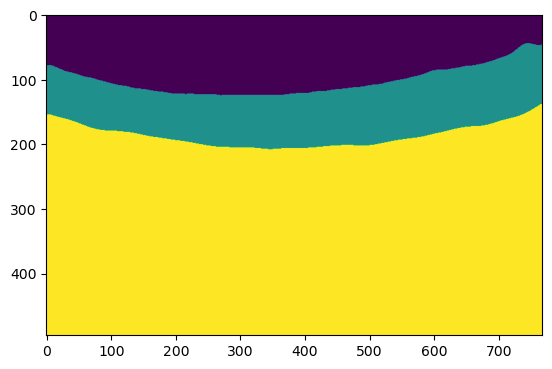

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch

truth = Image.open("results_segweights_final_run_1/truths/93022_440_622_4383_LNHP_0004.png")
truth_arr = torch.from_numpy(np.array(truth))
t_unique,t_counts = np.unique(truth_arr,return_counts=True)
# print(truth_arr.shape)
print(t_unique,t_counts)
pred = Image.open("results_segweights_final_run_1/preds/93022_440_622_4383_LNHP_0004.png")
pred_arr = torch.from_numpy(np.array(pred))
p_unique,p_counts = np.unique(pred_arr,return_counts=True)
plt.imshow(truth_arr)
print(p_unique,p_counts)

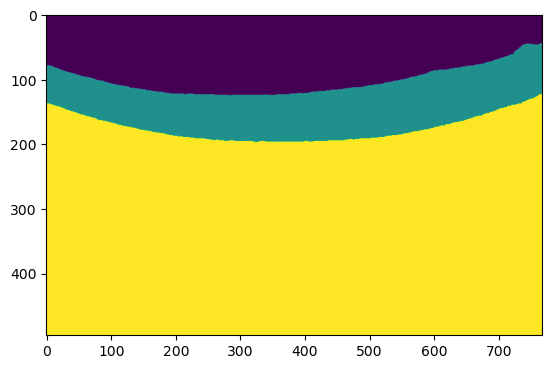

In [4]:
plt.imshow(pred_arr)

In [1]:
# truth = Image.open("results_segweights_final_run_1/truths/93022_440_622_4383_LNHP_0004.png")
# truth_arr = torch.from_numpy(np.array(truth))
# t_unique,t_counts = np.unique(truth_arr,return_counts=True)
# # print(truth_arr.shape)
# print(t_unique,t_counts)
# pred = Image.open("results_segweights_final_run_1/preds/93022_440_622_4383_LNHP_0004.png")
# pred_arr = torch.from_numpy(np.array(pred))
# p_unique,p_counts = np.unique(pred_arr,return_counts=True)
# plt.imshow(truth_arr)
# print(p_unique,p_counts)

NameError: name 'Image' is not defined

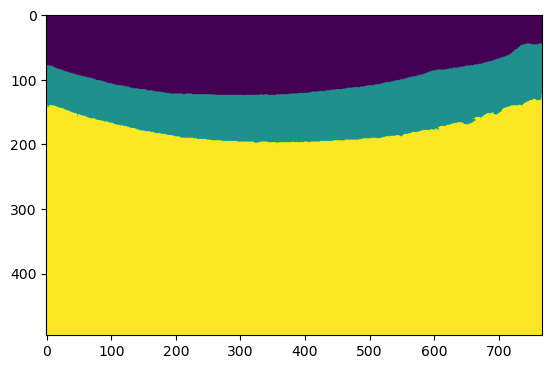

In [4]:
plt.imshow(pred_arr)

In [32]:
os.mkdir("results_segweights_run_1_half_y2_conv/display")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'results_segweights_run_1_half_y2_conv/display'

In [11]:

for root,dirs,files in os.walk("results_segweights_run_1_half_y2_conv/preds/"):
    for f in files:
        pred = Image.open(os.path.join(root,f))
        pred_arr = np.array(pred)
        pred_save = plt.imsave("results_segweights_final_run_3/display/" + f"{f}",pred_arr)

Dice testing

In [6]:
from torchmetrics import Dice
import torch as th

def test_dice(y_true,y_pred):
    pred_clone = y_pred.clone()
    true_clone = y_true.clone()
    
    pred_unique = th.unique(y_pred)
    true_unique = th.unique(y_true)
    print(f"pred unique: {pred_unique}")
    print(f"truth unique: {true_unique}")
    for i in range(len(pred_unique)):
        print(pred_clone[y_pred==pred_unique[i]])
        pred_clone[y_pred==pred_unique[i]] = i
        print(pred_clone[y_pred==pred_unique[i]])
        print("\n")
    
    for i in range(len(true_unique)):
        true_clone[y_true==true_unique[i]] = i

    multiclass_dice = Dice(num_classes=3,average="macro")
    multiclass_dice = multiclass_dice(pred_clone, true_clone)
    
    return float(multiclass_dice)


In [7]:
def msd_dice(y_true,y_pred):
    pred_clone = y_pred.clone()
    true_clone = y_true.clone()
    
    pred_unique = th.unique(y_pred)
    true_unique = th.unique(y_true)
    
    dices = []
    pred_list = []
    true_list = []
    # compare by each class
    for i in range(len(pred_unique)):
        # print(cls)
        pred_clone[pred_clone==pred_unique[i]] = i
    
    for i in range(len(true_unique)):
        # print(cls)
        true_clone[true_clone==true_unique[i]] = i

    for i in range(len(pred_unique)):
        pred_bool = th.where(pred_clone == i,True,False)
        true_bool = th.where(true_clone == i,True,False)
        pred_list.append(pred_bool)
        true_list.append(true_bool)

    for i in range(len(pred_unique)):
        intersection = th.logical_and(pred_list[i],true_list[i])
        dice = 2 * intersection.sum()/(pred_list[i].sum() + true_list[i].sum())
        print(dice)
        dices.append(dice)
    return np.average(dices)

    


In [14]:
cloned = msd_dice(truth_arr,pred_arr)
print(cloned)

tensor(0.9986)
tensor(0.9354)
tensor(0.9840)
0.97264916


In [15]:
dice = test_dice(truth_arr,pred_arr)
print(dice)

pred unique: tensor([0, 1, 2], dtype=torch.uint8)
truth unique: tensor([0, 1, 2], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)


tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.uint8)
tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.uint8)


tensor([2, 2, 2,  ..., 2, 2, 2], dtype=torch.uint8)
tensor([2, 2, 2,  ..., 2, 2, 2], dtype=torch.uint8)


0.9726492166519165


In [13]:
print(pred_arr.shape)
print(truth_arr.shape)

torch.Size([496, 768])
torch.Size([496, 768])


In [ ]:
truth = Image.open("final_results/truths/93022_440_622_4383_LNHP_0004.png")
truth_arr = torch.from_numpy(np.array(truth))

pred = Image.open("final_results/preds/93022_440_622_4383_LNHP_0004.png")
pred_arr = torch.from_numpy(np.array(pred))

In [86]:
# truth = Image.open("final_results/truths/93022_440_622_4383_LNHP_0004.png")
# truth_arr = torch.from_numpy(np.array(truth))

# pred = Image.open("final_results/preds/93022_440_622_4383_LNHP_0004.png")
# pred_arr = torch.from_numpy(np.array(pred))

dice = test_dice(truth_arr,pred_arr)
print(dice)

pred unique: tensor([0, 1, 2], dtype=torch.uint8)
truth unique: tensor([0, 1, 2], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)


tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.uint8)
tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.uint8)


tensor([2, 2, 2,  ..., 2, 2, 2], dtype=torch.uint8)
tensor([2, 2, 2,  ..., 2, 2, 2], dtype=torch.uint8)


0.9726492166519165


In [22]:
from datetime import date
cur_date = date.today().strftime("%d%m%Y")
# print(cur_date)
# str_date = str(cur_date).replace("-","")
# print(str_date)
num_folders = len(next(os.walk("data_snakemake/data"))[1])
print(num_folders)

3


In [32]:
path = os.getcwd()
cur_date = date.today().strftime("%d%m%Y")
dest = "data1/synthetic"
home = os.path.join(path,dest,cur_date)
print(home)
num_folders = str(len(next(os.walk(home))[1]) + 1)
print(num_folders)
home = os.path.join(path,dest,cur_date,num_folders)
print(home)

c:\Users\kenne\fedseg\data1/synthetic\25112022
1
c:\Users\kenne\fedseg\data1/synthetic\25112022\1


In [33]:
roots = []
directories = []
files  =[]
for root,dirs,file in os.walk("data_integrated/25112022/run_01/"):
    # directories.append(dirs)
    roots.append(root)
    directories.append(dirs)
    # if len(dirs)>0:
    #     directories.append(dirs)
    files.append(file)
#     print(dirs)
#     print(root)
#     print(files)
    # print(root)
# print(roots[5])
# print("evaluateewqewq" in roots[5])
# print(directories)
def create_mappings(base_dir,run_date,run_id):
    roots = []
    directories = []
    files = []
    for root,dirs,file in os.walk(f"{base_dir}/{run_date}/{run_id}"):
        roots.append(root)
        if len(dirs) > 0:
            directories.append(dirs)
        files.append(file)
    for folder in directories[0]:
        print(folder)
        pathlib.Path(f"{base_dir}/{run_date}/{run_id}/{folder}/mappings.csv").mkdir(parents=True,exist_ok=True)
# create_mappings("data_integrated","25112022","run_01")
print(len(roots))
# print(roots)
# print(len(directories))
# print(len(files))
# print(roots)
# print(directories)
# print(files)



16


In [83]:
def calc_dice(truth:torch.tensor,pred:torch.tensor)->float:
    """
    Calculates binary dice for each class and then returns the average dice across all classes

    Args:
        truth (torch.tensor): Ground truth
        pred (torch.tensor): Predictions from model

    Returns:
        dices: Dictionary containing the dice score of each class, and the average dice across all classes
    """
    pred_cpu = pred.cpu()
    true_cpu = truth.cpu()
    
    pred_unique = torch.unique(pred_cpu)
    true_unique = torch.unique(true_cpu)
    
    # dices = []
    dices = dict()
    pred_list = []
    true_list = []

    # convert the classes into 0,1,2,3,4,.....
    # E.g [banana,apple,lemon] -> [0,1,2]
    for i in range(len(pred_unique)):
        pred_cpu[pred_cpu==pred_unique[i]] = i
    
    for i in range(len(true_unique)):
        # print(cls)
        true_cpu[true_cpu==true_unique[i]] = i

    # Converts each class(0,1,2,3....) into boolean arrays and append them to a list
    # E.g
    # [0,0,0]    [1,1,1] [0,0,0] [0,0,0]
    # [1,1,1] => [0,0,0],[1,1,1],[0,0,0]
    # [2,2,2]    [0,0,0] [0,0,0] [1,1,1]
    # The resulting list will contain all the classes, with their index in the list corresponding to their class
    # E.g index[0] => class label 0
    for i in range(len(pred_unique)):
        pred_bool = torch.where(pred_cpu == i,True,False)
        true_bool = torch.where(true_cpu == i,True,False)
        pred_list.append(pred_bool)
        true_list.append(true_bool)

    for i in range(len(pred_unique)):
        intersection = torch.logical_and(pred_list[i],true_list[i])
        dice = 2 * intersection.sum()/(pred_list[i].sum() + true_list[i].sum())
        # dices.append(dice)
        dices[f"{i}"] = dice

    dices["avg"] = np.average(list(dices.values()))
    # return np.average(dices)
    return dices

In [84]:
def calc_individual_dice(root_dir:str):
    pred_path = os.path.join(root_dir,"preds")
    truth_path = os.path.join(root_dir,"truths")

    preds = sorted(os.listdir(pred_path))
    truths = sorted(os.listdir(truth_path))

    df = {
        "name":[],
        "avg":[],
        "0":[],
        "1":[],
        "2":[]
    }
    pair = zip(preds,truths)
    for p,t in pair:
        pred_img_path = os.path.join(pred_path,p)
        truth_img_path = os.path.join(truth_path,t)
        pred_mask = torch.from_numpy(np.array(Image.open(pred_img_path)))
        truth_mask = torch.from_numpy(np.array(Image.open(truth_img_path)))
        dice = calc_dice(pred_mask,truth_mask)
        # print(dice)
        df["name"].append(p)
        df["avg"].append(dice["avg"])
        df["0"].append(float(dice["0"]))
        df["1"].append(float(dice["1"]))
        df["2"].append(float(dice["2"]))
        # data = pd.DataFrame({"name":p,"avg":dice["avg"],"0":dice["0"],"1":dice["1"],"2":dice["2"]})
        # print(f"name:{p}, {dice}")
        # pd.concat(data)
    return pd.DataFrame(df)


# preds = os.listdir("results_segweights_run_1_half_y2_conv/preds/")
# print(len(preds))
df = calc_individual_dice(root_dir="results_segweights_run_1_half_y2_conv")

In [87]:
df.to_csv()

,name,avg,0,1,2
0,1257012_1705_2570_15354_RNHP_0001.png,0.979659,0.971820,0.968539,0.998616
1,1257012_1705_2570_15354_RNHP_0002.png,0.993585,0.993037,0.988728,0.998990
2,1257012_1705_2570_15354_RNHP_0003.png,0.993845,0.993826,0.988727,0.998982
3,1257012_1705_2570_15354_RNHP_0006.png,0.996277,0.997746,0.992438,0.998646
4,1257012_1705_2570_15354_RNHP_0008.png,0.995656,0.997741,0.991079,0.998148
...,...,...,...,...,...
1195,93022_440_622_4383_LNHP_0024.png,0.972902,0.997889,0.935098,0.985717
1196,93022_440_622_4383_LNHP_0025.png,0.971309,0.997961,0.930987,0.984979
1197,93022_440_622_4383_LNHP_0026.png,0.970121,0.998135,0.928269,0.983960
1198,93022_440_622_4383_LNHP_0027.png,0.972538,0.998092,0.933490,0.986032


In [93]:
df["1"].mean()

0.9891269385814667